In [1]:
%load_ext autoreload
%autoreload
from IPython.display import clear_output

import os
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

import sys
import subprocess
import pdb
import time
import datetime
import math
import random
import _pickle as cPickle
from collections import defaultdict
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib nbagg

from six.moves import zip_longest
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import distributions as tfd
from tensorflow.keras.preprocessing.sequence import pad_sequences

from data_structure import get_batches, get_test_batches
from components import tf_log, sample_latents, compute_kl_loss, dynamic_rnn, dynamic_bi_rnn

from topic_beam_search_decoder import BeamSearchDecoder

In [2]:
PAD = '<pad>' # This has a vocab id, which is used to pad the encoder input, decoder input and target sequence
UNK = '<unk>' # This has a vocab id, which is used to represent out-of-vocabulary words
BOS = '<p>' # This has a vocab id, which is used at the beginning of every decoder input sequence
EOS = '</p>' # This has a vocab id, which is used at the end of untruncated target sequences

# load data & set config

In [230]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)

flags = tf.app.flags

flags.DEFINE_string('gpu', '0', 'visible gpu')

flags.DEFINE_string('mode', 'train', 'set train or eval')

flags.DEFINE_string('data_path', 'data/synthetic/instances.pkl', 'path of data')
flags.DEFINE_string('modeldir', 'model/topic_vae', 'directory of model')
flags.DEFINE_string('modelname', 'bags', 'name of model')

flags.DEFINE_integer('epochs', 1000, 'epochs')
flags.DEFINE_integer('batch_size', 64, 'number of sentences in each batch')
flags.DEFINE_integer('log_period', 1000, 'valid period')

flags.DEFINE_string('opt', 'Adagrad', 'optimizer')
# flags.DEFINE_string('opt', 'Adam', 'optimizer')
flags.DEFINE_float('lr', 0.01, 'lr')
flags.DEFINE_float('reg', 10., 'regularization term')
flags.DEFINE_float('grad_clip', 5., 'grad_clip')

flags.DEFINE_float('keep_prob', 0.8, 'dropout rate')
flags.DEFINE_float('word_keep_prob', 0.75, 'word dropout rate')

flags.DEFINE_bool('warmup', True, 'flg of warming up')
flags.DEFINE_integer('epochs_cycle', 5, 'number of epochs within a cycle')
flags.DEFINE_float('r_cycle', 0.5, 'proportion used to increase beta within a cycle')
flags.DEFINE_integer('warmup_topic', 0, 'warmup period for KL of topic')

flags.DEFINE_integer('beam_width', 2, 'beam_width')
flags.DEFINE_float('length_penalty_weight', 0.0, 'length_penalty_weight')

flags.DEFINE_integer('n_topic', 20, 'number of topic')
flags.DEFINE_integer('dim_hidden_bow', 256, 'dim of hidden bow')
flags.DEFINE_integer('dim_latent_bow', 32, 'dim of latent topic')
flags.DEFINE_integer('dim_emb', 256, 'dim_emb')
flags.DEFINE_integer('dim_hidden', 512, 'dim_hidden')
flags.DEFINE_integer('dim_hidden_topic', 512, 'dim_hidden_topic')
flags.DEFINE_integer('dim_latent', 32, 'dim_latent')
flags.DEFINE_bool('bidirectional', True, 'flg of bidirectional encoding')

# for evaluation
flags.DEFINE_string('refdir', 'ref', 'refdir')
flags.DEFINE_string('outdir', 'out', 'outdir')

flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_bool('logtostderr', True, 'kernel')
flags.DEFINE_bool('showprefixforinfo', False, '')
flags.DEFINE_bool('verbosity', False, '')
# flags.DEFINE_integer('stderrthreshold', 20, 'kernel')

config = flags.FLAGS

flags.DEFINE_string('modelpath', os.path.join(config.modeldir, config.modelname), 'path of model')

In [231]:
os.environ["CUDA_VISIBLE_DEVICES"] = config.gpu

In [232]:
instances_train, instances_dev, instances_test, word_to_idx, idx_to_word, bow_idxs = cPickle.load(open(config.data_path,'rb'))

In [233]:
def get_batches(instances, batch_size, iterator=False):
    iter_instances = iter(instances)
    n_batch = len(instances)//batch_size
    
    batches = [(i_batch, [next(iter_instances) for i_doc in range(batch_size)]) for i_batch in range(n_batch)]
    
    if iterator: batches = iter(batches)
    return batches

train_batches = get_batches(instances_train, config.batch_size)
dev_batches = get_batches(instances_dev, config.batch_size)
test_batches = get_batches(instances_test, config.batch_size)

In [234]:
flags.DEFINE_integer('n_vocab', len(word_to_idx), 'n_vocab')
flags.DEFINE_integer('dim_bow', len(bow_idxs), 'dim_bow')

flags.DEFINE_integer('cycle_steps', len(train_batches)*config.epochs_cycle, 'number of steps for each cycle')

In [235]:
def debug_shape(variables):
    sample_batch = dev_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)
    for _variable, variable in zip(_variables, variables):
        if hasattr(variable, 'name'):
            print(variable.name, ':', _variable.shape)
        else:
            print(_variable.shape)

def debug_value(variables, return_value=False):
    sample_batch = test_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)

    if return_value: 
        return _variables
    else:
        for _variable, variable in zip(_variables, variables):
            if hasattr(variable, 'name'):
                print(variable.name, ':', _variable)
            else:
                print(_variable)
                
def check_shape(variables):
    if 'sess' in globals(): raise
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    sample_batch = test_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)
    for _variable, variable in zip(_variables, variables):
        if hasattr(variable, 'name'):
            print(variable.name, ':', _variable.shape)
        else:
            print(_variable.shape)
            
    sess.close()
    
def check_value(variables):
    if 'sess' in globals(): raise
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    sample_batch = test_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)
    for _variable, variable in zip(_variables, variables):
        if hasattr(variable, 'name'):
            print(variable.name, ':', _variable)
        else:
            print(_variable.shape)
            
    sess.close()    
    

# run model 

## init

In [236]:
def get_feed_dict(batch, mode='train'):
    bow = np.array([instance.bow for instance in batch]).astype(np.float32)
    keep_prob = config.keep_prob if mode == 'train' else 1.0
    feed_dict = {
                t_variables['bow']: bow, 
                t_variables['keep_prob']: keep_prob
    }
    return  feed_dict

In [237]:
tf.reset_default_graph()

t_variables = {}
t_variables['bow'] = tf.placeholder(tf.float32, [None, config.dim_bow])
t_variables['keep_prob'] = tf.placeholder(tf.float32)

# tree_idxs = {0:[1, 2], 
#              1:[10, 11], 2:[20, 21, 22], 
#              10: [100, 101], 11: [110, 111, 112], 20: [200, 201], 21: [210, 211], 22:[220, 221, 222]
#              }

# tree_idxs = {0:[1, 2, 3], 
#                       1:[10, 11], 2:[20, 21], 3:[30, 31]}

tree_idxs = {0:[1, 2, 3], 
              1:[10, 11, 12], 2:[20, 21, 22], 3:[30, 31, 32]}


# tree_idxs = {0:[1, 2, 3], 
#                       1:[10, 11], 2:[20, 21], 3:[30, 31],
#                       10: [100, 101], 11: [110, 111], 20: [200, 201], 21: [210, 211], 30:[300, 301], 31:[310, 311]}

topic_idxs = [0] + [idx for child_idxs in tree_idxs.values() for idx in child_idxs]

## doubly rnn

In [238]:
class DoublyRNNCell:
    def __init__(self, dim_hidden, output_layer=None):
        self.dim_hidden = dim_hidden
        
        self.ancestral_layer=tf.layers.Dense(units=dim_hidden, activation=tf.nn.tanh, name='ancestral')
        self.fraternal_layer=tf.layers.Dense(units=dim_hidden, activation=tf.nn.tanh, name='fraternal')
        self.hidden_layer = tf.layers.Dense(units=dim_hidden, activation=tf.nn.tanh, name='hidden')
        
        self.output_layer=output_layer
        
    def __call__(self, state_ancestral, state_fraternal, reuse=True):
        with tf.variable_scope('input', reuse=reuse):
            state_ancestral = self.ancestral_layer(state_ancestral)
            state_fraternal = self.fraternal_layer(state_fraternal)

        with tf.variable_scope('output', reuse=reuse):
            state_hidden = self.hidden_layer(state_ancestral + state_fraternal)
            if self.output_layer is not None: 
                output = self.output_layer(state_hidden)
            else:
                output = state_hidden
            
        return output, state_hidden
    
    def get_initial_state(self, name):
        initial_state = tf.get_variable(name, [1, self.dim_hidden], dtype=tf.float32)
        return initial_state
    
    def get_zero_state(self, name):
        zero_state = tf.zeros([1, self.dim_hidden], dtype=tf.float32, name=name)
        return zero_state

In [239]:
def doubly_rnn(dim_hidden, tree_idxs, initial_state_parent=None, initial_state_sibling=None, output_layer=None, name=''):
    outputs, states_parent = {}, {}
    
    with tf.variable_scope(name, reuse=False):
        doubly_rnn_cell = DoublyRNNCell(dim_hidden, output_layer)

        if initial_state_parent is None: 
            initial_state_parent = doubly_rnn_cell.get_initial_state('init_state_parent')
#             initial_state_parent = doubly_rnn_cell.get_zero_state('init_state_parent')
        if initial_state_sibling is None: 
#             initial_state_sibling = doubly_rnn_cell.get_initial_state('init_state_sibling')
            initial_state_sibling = doubly_rnn_cell.get_zero_state('init_state_sibling')
        output, state_sibling = doubly_rnn_cell(initial_state_parent, initial_state_sibling, reuse=False)
        outputs[0], states_parent[0] = output, state_sibling

        for parent_idx, child_idxs in tree_idxs.items():
            state_parent = states_parent[parent_idx]
            state_sibling = initial_state_sibling
            for child_idx in child_idxs:
                output, state_sibling = doubly_rnn_cell(state_parent, state_sibling)
                outputs[child_idx], states_parent[child_idx] = output, state_sibling

    return outputs, states_parent

## stick break

In [240]:
def hierarchical_sbp(tree_sticks_topic, tree_sticks_branch):
    tree_prob_topic = {}
    rest_topics = {}

    # calculate topic probability and save
    stick_topic = tree_sticks_topic[0]
    tree_prob_topic[0] = stick_topic
    rest_topics[0] = 1.-stick_topic
    for parent_idx, child_idxs in tree_idxs.items():
        rest_topic = rest_topics[parent_idx]
        rest_branch = 1.
        for child_idx in child_idxs:
            # calculate topic probability
            if child_idx == child_idxs[-1]: # last child
                prob_branch = rest_branch # phi
            else:
                stick_branch = tree_sticks_branch[child_idx] # psi
                prob_branch = stick_branch * rest_branch # phi

            if not child_idx in tree_idxs: # leaf childs
                prob_topic = prob_branch * rest_topic # pi
            else:
                stick_topic = tree_sticks_topic[child_idx] # upsilon
                prob_topic = stick_topic * prob_branch * rest_topic # pi

            # save topic probability and update rest stick length
            tree_prob_topic[child_idx] = prob_topic
            rest_branch = (1.- stick_branch) * rest_branch
            rest_topics[child_idx] = (1.-stick_topic)*prob_branch * rest_topic
            
    return tree_prob_topic

## build model

In [241]:
def get_tree_topic_bow(tree_topic_embeddings):
    def get_depth(parent_idx=0, tree_depth = None, depth=1):
        if tree_depth is None: tree_depth={0: depth}

        child_idxs = tree_idxs[parent_idx]
        depth +=1
        for child_idx in child_idxs:
            tree_depth[child_idx] = depth
            if child_idx in tree_idxs: get_depth(child_idx, tree_depth, depth)
        return tree_depth
       
    def softmax_with_temperature(logits, axis=None, name=None, temperature=1.):
        if axis is None:
            axis = -1
        return tf.exp(logits / temperature) / tf.reduce_sum(tf.exp(logits / temperature), axis=axis)
    
    tree_depth = get_depth()

    tree_topic_bow = {}
    for topic_idx, depth in tree_depth.items():
        topic_embedding = tree_topic_embeddings[topic_idx]
        temperature = tf.constant(100. ** (1./depth), dtype=tf.float32)
        logits = tf.matmul(topic_embedding, bow_embeddings, transpose_b=True)
        tree_topic_bow[topic_idx] = softmax_with_temperature(logits, axis=-1, temperature=temperature)
    
    return tree_topic_bow

In [242]:
# encode bow
with tf.variable_scope('topic/enc', reuse=False):
    hidden_bow_ = tf.layers.Dense(units=config.dim_hidden_bow, activation=tf.nn.tanh, name='hidden_bow')(t_variables['bow'])
    hidden_bow = tf.layers.Dropout(t_variables['keep_prob'])(hidden_bow_)
    means_bow = tf.layers.Dense(units=config.dim_latent_bow, name='mean_bow')(hidden_bow)
    logvars_bow = tf.layers.Dense(units=config.dim_latent_bow, kernel_initializer=tf.constant_initializer(0), bias_initializer=tf.constant_initializer(0), name='logvar_bow')(hidden_bow)
    latents_bow = sample_latents(means_bow, logvars_bow) # sample latent vectors
    prob_layer = lambda h: tf.nn.sigmoid(tf.matmul(latents_bow, h, transpose_b=True))
    
    tree_sticks_topic, tree_states_sticks_topic = doubly_rnn(config.dim_latent_bow, tree_idxs, output_layer=prob_layer, name='sticks_topic')
    tree_sticks_branch, tree_states_sticks_branch = doubly_rnn(config.dim_latent_bow, tree_idxs, output_layer=prob_layer, name='sticks_branch')

    tree_prob_topic = hierarchical_sbp(tree_sticks_topic, tree_sticks_branch)
    prob_topic = tf.concat([tree_prob_topic[topic_idx] for topic_idx in topic_idxs], 1)

# decode bow
with tf.variable_scope('shared', reuse=False):
    embeddings = tf.get_variable('emb', [config.n_vocab, config.dim_emb], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer()) # embeddings of vocab

bow_embeddings = tf.nn.embedding_lookup(embeddings, bow_idxs) # embeddings of each bow features

with tf.variable_scope('topic/dec', reuse=False):
    emb_layer = tf.layers.Dense(units=config.dim_emb, name='output')
    tree_topic_embeddings, tree_states_topic_embeddings = doubly_rnn(config.dim_emb, tree_idxs, output_layer=emb_layer, name='emb_topic')
#     topic_embeddings = tf.get_variable('topic_emb', [len(topic_idxs), config.dim_emb], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer()) # embeddings of topics
#     tree_topic_embeddings = {topic_idx: tf.expand_dims(topic_embeddings[topic_idxs.index(topic_idx)], 0) for topic_idx in topic_idxs}

    tree_topic_bow = get_tree_topic_bow(tree_topic_embeddings) # bow vectors for each topic
    
    topic_bow = tf.concat([tree_topic_bow[topic_idx] for topic_idx in topic_idxs], 0)
    logits_bow = tf_log(tf.matmul(prob_topic, topic_bow)) # predicted bow distribution

## define loss

In [243]:
def get_tree_mask_reg(tree_idxs):
    tree_mask_reg = np.ones([len(topic_idxs), len(topic_idxs)], dtype=np.float32)
    parent_to_descendant_idxs = {parent_idx: get_descendant_idxs(parent_idx) for parent_idx in tree_idxs}
    
    for parent_idx, descendant_idxs in parent_to_descendant_idxs.items():
        for descendant_idx in descendant_idxs:
            tree_mask_reg[topic_idxs.index(parent_idx), topic_idxs.index(descendant_idx)] = tree_mask_reg[topic_idxs.index(descendant_idx), topic_idxs.index(parent_idx)] = 0.
            
    return tree_mask_reg

def get_depth_mask_reg(tree_idxs):
    depth_mask_reg = np.zeros([len(topic_idxs), len(topic_idxs)], dtype=np.float32)
    
    depth_mask_reg[0, 0] = 1.
    for parent_idx, child_idxs in tree_idxs.items():
        for child_idx1 in child_idxs:
            for child_idx2 in child_idxs:
                depth_mask_reg[topic_idxs.index(child_idx1), topic_idxs.index(child_idx2)] = 1.
                
    return depth_mask_reg

def get_descendant_idxs(parent_idx, descendant_idxs = None):
    if descendant_idxs is None: descendant_idxs = []
    
    child_idxs = tree_idxs[parent_idx]
    descendant_idxs += child_idxs
    for child_idx in child_idxs:
        if child_idx in tree_idxs: get_descendant_idxs(child_idx, descendant_idxs)
    return descendant_idxs

In [244]:
# define losses
topic_losses_recon = -tf.reduce_sum(tf.multiply(t_variables['bow'], logits_bow), 1)
topic_loss_recon = tf.reduce_mean(topic_losses_recon) # negative log likelihood of each words

topic_loss_kl = compute_kl_loss(means_bow, logvars_bow) # KL divergence b/w latent dist & gaussian std

topic_bow_norm = topic_bow / tf.norm(topic_bow, axis=1, keepdims=True)
topic_dots = tf.clip_by_value(tf.matmul(topic_bow_norm, tf.transpose(topic_bow_norm)), -1., 1.)
# topic_loss_reg = tf.reduce_mean(tf.square(topic_dots - tf.eye(len(topic_idxs))))
tree_mask_reg = get_tree_mask_reg(tree_idxs)
# tree_mask_reg = get_depth_mask_reg(tree_idxs)
topic_losses_reg = tf.square(topic_dots - tf.eye(len(topic_idxs))) * tree_mask_reg
topic_loss_reg = tf.reduce_sum(topic_losses_reg) / tf.reduce_sum(tree_mask_reg)

# topic_embeddings = tf.concat([tree_topic_embeddings[topic_idx] for topic_idx in topic_idxs], 0)
# topic_embeddings_norm = topic_embeddings / tf.norm(topic_embeddings, axis=1, keepdims=True)
# topic_dots = tf.clip_by_value(tf.matmul(topic_embeddings_norm, tf.transpose(topic_embeddings_norm)), -1., 1.)
# tree_mask_reg = get_tree_mask_reg(tree_idxs)
# topic_loss_reg = tf.reduce_sum(tf.square(topic_dots - tf.eye(len(topic_idxs))) * tree_mask_reg) / tf.reduce_sum(tree_mask_reg)

# topic_embeddings = tf.concat([tree_topic_embeddings[topic_idx] for topic_idx in topic_idxs], 0)
# topic_embeddings_norm = topic_embeddings / tf.norm(topic_embeddings, axis=1, keepdims=True)
# topic_dots = tf.clip_by_value(tf.matmul(topic_embeddings_norm, tf.transpose(topic_embeddings_norm)), -1., 1.)
# topic_angles = tf.acos(topic_dots)
# tree_mask_reg = get_tree_mask_reg(tree_idxs)

# mean_angles = tf.reduce_sum(topic_angles*tree_mask_reg) / tf.reduce_sum(tree_mask_reg)
# var_angles = tf.reduce_sum(tf.square(topic_angles-mean_angles)*tree_mask_reg) / tf.reduce_sum(tree_mask_reg)
# mean_angles = tf.reduce_mean(topic_angles)
# var_angles = tf.reduce_mean(tf.square(topic_angles-mean_angles))
# mean_angles = tf.asin(tf.sqrt(tf.linalg.det(topic_dots * tree_mask_reg)))
# var_angles = tf.square(tf.constant(np.pi/2., dtype=tf.float32)-mean_angles)

# topic_loss_reg = var_angles - mean_angles

global_step = tf.Variable(0, name='global_step',trainable=False)

loss = topic_loss_recon + topic_loss_kl + config.reg * topic_loss_reg

# define optimizer
if config.opt == 'Adam':
    optimizer = tf.train.AdamOptimizer(config.lr)
elif config.opt == 'Adagrad':
    optimizer = tf.train.AdagradOptimizer(config.lr)

grad_vars = optimizer.compute_gradients(loss)
clipped_grad_vars = [(tf.clip_by_value(grad, -config.grad_clip, config.grad_clip), var) for grad, var in grad_vars]
opt = optimizer.apply_gradients(clipped_grad_vars, global_step=global_step)

# monitor
n_bow = tf.reduce_sum(t_variables['bow'], 1)
topic_ppls = tf.divide(topic_losses_recon, tf.maximum(1e-5, n_bow))
topics_freq_bow_indices = tf.nn.top_k(topic_bow, 5, name='topic_freq_bow').indices

In [245]:
def get_loss(sess, batches):
    losses = []
    ppl_list = []
    for ct, batch in batches:
        feed_dict = get_feed_dict(batch, mode='test')
        loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch, ppls_batch \
            = sess.run([loss, topic_loss_recon, topic_loss_kl, topic_loss_reg, topic_ppls], feed_dict = feed_dict)
        losses += [[loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch]]
        ppl_list += list(ppls_batch)
    loss_mean, topic_loss_recon_mean, topic_loss_kl_mean, topic_loss_reg_mean = np.mean(losses, 0)
    ppl_mean = np.exp(np.mean(ppl_list))
    return loss_mean, topic_loss_recon_mean, topic_loss_kl_mean, topic_loss_reg_mean, ppl_mean

In [246]:
from matplotlib.colors import Normalize # Normalizeをimport

def print_topic_sample():
    _topics_bow = sess.run(topic_bow)
    plt.figure(figsize=(9, 15))
    
    _topic_bow = _topics_bow[0]
    plt.subplot(5,3,2)
    plt.axis('off')
    plt.title(topic_idxs[0])
    plt.imshow(_topic_bow.reshape(30,30), cmap='Wistia', norm=Normalize(vmin=0., vmax=0.01))
    
    for i in range(1, len(topic_idxs)):
        _topic_bow = _topics_bow[i]
        plt.subplot(5,3,i+3)
        plt.axis('off')
        plt.title(topic_idxs[i])
        plt.imshow(_topic_bow.reshape(30,30), cmap='Wistia', norm=Normalize(vmin=0., vmax=0.01))
        
    plt.show()

In [247]:
if 'sess' in globals(): sess.close()
sess = tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1))
sess.run(tf.global_variables_initializer())

losses_train = []
ppls_train = []
loss_min = np.inf
beta_eval = 1.
epoch = 0
train_batches = get_batches(instances_train, config.batch_size, iterator=True)
saver = tf.train.Saver(max_to_keep=10)

log_df = pd.DataFrame(columns=pd.MultiIndex.from_tuples(
                    list(zip(*[['','','','TRAIN:','TM','','','','VALID:','TM','','',''],
                            ['Time','Ep','Ct','LOSS','PPL','NLL','KL','REG','LOSS','PPL','NLL','KL','REG']]))))

TRAIN:   TM                      VALID:   TM          \
       Time   Ep   Ct    LOSS  PPL     NLL    KL   REG    LOSS  PPL     NLL   
1000     19    6   63  679.31  837  672.99  2.05  0.43  674.49  813  670.06   
2000     17   12  127  675.85  817  670.53  2.52  0.28  670.97  786  666.64   
3000     17   19   35  674.21  806  669.22  2.84  0.22  670.43  781  666.11   
4000     17   25   99  673.24  800  668.40  3.05  0.18  669.79  776  665.42   
5000     17   32    7  672.55  795  667.81  3.22  0.15  669.40  773  665.02   
6000     17   38   71  672.04  791  667.38  3.34  0.13  669.18  771  664.77   
7000     17   44  135  671.65  789  667.04  3.44  0.12  669.03  771  664.71   
8000     17   51   43  671.35  787  666.77  3.52  0.11  668.86  769  664.48   
9000     17   57  107  671.09  785  666.54  3.59  0.10  668.69  768  664.37   
10000    17   64   15  670.88  783  666.34  3.65  0.09  668.62  766  664.18   
11000    17   70   79  670.69  782  666.17  3.71  0.08  668.64  766  664.10   
12000    17   76  143  670.53  781  666.02  3.76  0.08  668.59  766  664.10   
13000    17   83   51  670.39  780  665.88  3.80  0.07  668.47  764  663.91   
14000    17   89  115  670.27  779  665.76  3.85  0.07  668.49  765  663.93   
15000    17   96   23  670.16  778  665.64  3.89  0.06  668.35  762  663.65   
16000    17  102   87  670.05  777  665.53  3.93  0.06  668.38  763  663.69   
17000    18  108  151  669.95  776  665.42  3.97  0.06  668.17  760  663.39   
18000    18  115   59  669.86  775  665.31  4.01  0.05  668.00  759  663.23   
19000    18  121  123  669.78  774  665.22  4.05  0.05  668.06  759  663.23   
20000    18  128   31  669.70  774  665.12  4.09  0.05  668.08  759  663.23   
21000    18  134   95  669.63  773  665.04  4.12  0.05  668.11  759  663.24   
22000    18  141    3  669.56  772  664.95  4.15  0.05  668.00  758  663.07   
23000    18  147   67  669.50  772  664.88  4.18  0.04  668.06  758  663.07   
24000    18  153  131  669.44  771  664.81  4.21  0.04  667.96  758  663.02   
25000    18  160   39  669.38  771  664.74  4.24  0.04  667.89  757  662.92   
26000    18  166  103  669.33  770  664.67  4.26  0.04  667.95  757  662.96   
27000    18  173   11  669.28  770  664.61  4.29  0.04  667.88  756  662.87   
28000    18  179   75  669.23  769  664.55  4.31  0.04  667.74  756  662.79   
29000    18  185  139  669.19  769  664.50  4.33  0.04  667.97  757  662.95   
30000    18  192   47  669.15  769  664.44  4.36  0.03  667.92  757  662.92   
...     ...  ...  ...     ...  ...     ...   ...   ...     ...  ...     ...   
127000   20  814   15  667.98  758  663.11  4.91  0.01  667.51  753  662.42   
128000   20  820   79  667.98  758  663.11  4.91  0.01  667.80  755  662.67   
129000   19  826  143  667.97  757  663.11  4.91  0.01  667.70  754  662.59   
130000   20  833   51  667.97  757  663.11  4.91  0.01  667.68  754  662.53   
131000   19  839  115  667.96  757  663.11  4.92  0.01  667.75  755  662.66   
132000   20  846   23  667.95  757  663.10  4.92  0.01  667.68  754  662.59   
133000   21  852   87  667.95  757  663.10  4.92  0.01  667.59  753  662.43   
134000   20  858  151  667.94  757  663.10  4.92  0.01  667.72  754  662.60   
135000   21  865   59  667.94  757  663.10  4.92  0.01  667.74  755  662.65   
136000   20  871  123  667.93  757  663.10  4.92  0.01  667.72  755  662.64   
137000   20  878   31  667.93  757  663.10  4.92  0.01  667.69  754  662.59   
138000   20  884   95  667.93  757  663.10  4.93  0.01  667.82  755  662.74   
139000   20  891    3  667.92  757  663.10  4.93  0.01  667.77  755  662.67   
140000   20  897   67  667.92  757  663.09  4.93  0.01  667.67  754  662.55   
141000   21  903  131  667.91  757  663.09  4.93  0.01  667.70  754  662.59   
142000   20  910   39  667.91  757  663.09  4.93  0.01  667.62  754  662.52   
143000   20  916  103  667.90  757  663.09  4.93  0.01  667.64  754  662.53   
144000   20  923   11  667.90  757  663.09  4.93  0.01  667.71  754  662.

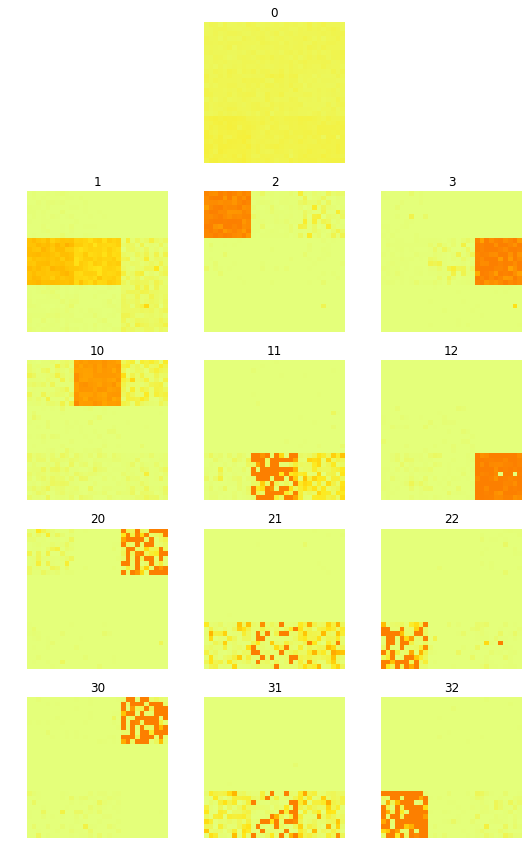

TRAIN:   TM                      VALID:   TM          \
       Time   Ep   Ct    LOSS  PPL     NLL    KL   REG    LOSS  PPL     NLL   
1000     19    6   63  679.31  837  672.99  2.05  0.43  674.49  813  670.06   
2000     17   12  127  675.85  817  670.53  2.52  0.28  670.97  786  666.64   
3000     17   19   35  674.21  806  669.22  2.84  0.22  670.43  781  666.11   
4000     17   25   99  673.24  800  668.40  3.05  0.18  669.79  776  665.42   
5000     17   32    7  672.55  795  667.81  3.22  0.15  669.40  773  665.02   
6000     17   38   71  672.04  791  667.38  3.34  0.13  669.18  771  664.77   
7000     17   44  135  671.65  789  667.04  3.44  0.12  669.03  771  664.71   
8000     17   51   43  671.35  787  666.77  3.52  0.11  668.86  769  664.48   
9000     17   57  107  671.09  785  666.54  3.59  0.10  668.69  768  664.37   
10000    17   64   15  670.88  783  666.34  3.65  0.09  668.62  766  664.18   
11000    17   70   79  670.69  782  666.17  3.71  0.08  668.64  766  664.10   
12000    17   76  143  670.53  781  666.02  3.76  0.08  668.59  766  664.10   
13000    17   83   51  670.39  780  665.88  3.80  0.07  668.47  764  663.91   
14000    17   89  115  670.27  779  665.76  3.85  0.07  668.49  765  663.93   
15000    17   96   23  670.16  778  665.64  3.89  0.06  668.35  762  663.65   
16000    17  102   87  670.05  777  665.53  3.93  0.06  668.38  763  663.69   
17000    18  108  151  669.95  776  665.42  3.97  0.06  668.17  760  663.39   
18000    18  115   59  669.86  775  665.31  4.01  0.05  668.00  759  663.23   
19000    18  121  123  669.78  774  665.22  4.05  0.05  668.06  759  663.23   
20000    18  128   31  669.70  774  665.12  4.09  0.05  668.08  759  663.23   
21000    18  134   95  669.63  773  665.04  4.12  0.05  668.11  759  663.24   
22000    18  141    3  669.56  772  664.95  4.15  0.05  668.00  758  663.07   
23000    18  147   67  669.50  772  664.88  4.18  0.04  668.06  758  663.07   
24000    18  153  131  669.44  771  664.81  4.21  0.04  667.96  758  663.02   
25000    18  160   39  669.38  771  664.74  4.24  0.04  667.89  757  662.92   
26000    18  166  103  669.33  770  664.67  4.26  0.04  667.95  757  662.96   
27000    18  173   11  669.28  770  664.61  4.29  0.04  667.88  756  662.87   
28000    18  179   75  669.23  769  664.55  4.31  0.04  667.74  756  662.79   
29000    18  185  139  669.19  769  664.50  4.33  0.04  667.97  757  662.95   
30000    18  192   47  669.15  769  664.44  4.36  0.03  667.92  757  662.92   
...     ...  ...  ...     ...  ...     ...   ...   ...     ...  ...     ...   
127000   20  814   15  667.98  758  663.11  4.91  0.01  667.51  753  662.42   
128000   20  820   79  667.98  758  663.11  4.91  0.01  667.80  755  662.67   
129000   19  826  143  667.97  757  663.11  4.91  0.01  667.70  754  662.59   
130000   20  833   51  667.97  757  663.11  4.91  0.01  667.68  754  662.53   
131000   19  839  115  667.96  757  663.11  4.92  0.01  667.75  755  662.66   
132000   20  846   23  667.95  757  663.10  4.92  0.01  667.68  754  662.59   
133000   21  852   87  667.95  757  663.10  4.92  0.01  667.59  753  662.43   
134000   20  858  151  667.94  757  663.10  4.92  0.01  667.72  754  662.60   
135000   21  865   59  667.94  757  663.10  4.92  0.01  667.74  755  662.65   
136000   20  871  123  667.93  757  663.10  4.92  0.01  667.72  755  662.64   
137000   20  878   31  667.93  757  663.10  4.92  0.01  667.69  754  662.59   
138000   20  884   95  667.93  757  663.10  4.93  0.01  667.82  755  662.74   
139000   20  891    3  667.92  757  663.10  4.93  0.01  667.77  755  662.67   
140000   20  897   67  667.92  757  663.09  4.93  0.01  667.67  754  662.55   
141000   21  903  131  667.91  757  663.09  4.93  0.01  667.70  754  662.59   
142000   20  910   39  667.91  757  663.09  4.93  0.01  667.62  754  662.52   
143000   20  916  103  667.90  757  663.09  4.93  0.01  667.64  754  662.53   
144000   20  923   11  667.90  757  663.09  4.93  0.01  667.71  754  662.

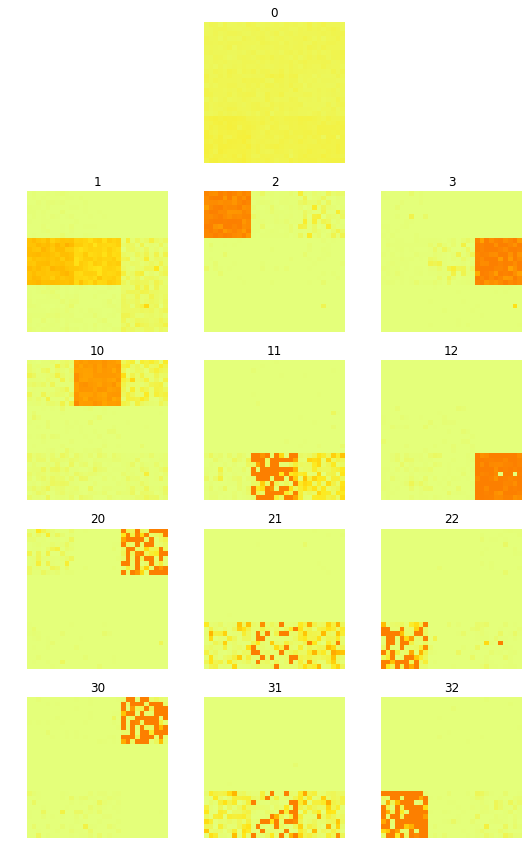

In [248]:
if len(log_df) == 0:
    cmd_rm = 'rm -r %s' % config.modeldir
    res = subprocess.call(cmd_rm.split())

    cmd_mk = 'mkdir %s' % config.modeldir
    res = subprocess.call(cmd_mk.split())

time_start = time.time()
while epoch < config.epochs:
    for ct, batch in train_batches:
        feed_dict = get_feed_dict(batch)

        _, loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch, ppls_batch, global_step_log = \
        sess.run([opt, loss, topic_loss_recon, topic_loss_kl, topic_loss_reg, topic_ppls, tf.train.get_global_step()], feed_dict = feed_dict)
            
        losses_train += [[loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch]]
        ppls_train += list(ppls_batch)

        if global_step_log%config.log_period==0:
            loss_train, topic_loss_recon_train, topic_loss_kl_train, topic_loss_reg_train = np.mean(losses_train, 0)
            ppl_train = np.exp(np.mean(ppls_train))
            loss_dev, topic_loss_recon_dev, topic_loss_kl_dev, topic_loss_reg_dev, ppl_dev = get_loss(sess, dev_batches)
            
#             if loss_dev < loss_min:
#                 loss_min = loss_dev
#                 saver.save(sess, config.modelpath, global_step=global_step_log)

            clear_output()
    
            time_log = int(time.time() - time_start)
            log_series = pd.Series([time_log, epoch, ct, \
                    '%.2f'%loss_train, '%.0f'%ppl_train, '%.2f'%topic_loss_recon_train, '%.2f'%topic_loss_kl_train, '%.2f'%topic_loss_reg_train, \
                    '%.2f'%loss_dev, '%.0f'%ppl_dev, '%.2f'%topic_loss_recon_dev, '%.2f'%topic_loss_kl_dev, '%.2f'%topic_loss_reg_dev],
                    index=log_df.columns)
            log_df.loc[global_step_log] = log_series
            display(log_df)
            
            # visualize topic
            print_topic_sample()

            time_start = time.time()
            
    epoch += 1
    train_batches = get_batches(instances_train, config.batch_size, iterator=True)
    
display(log_df)
print_topic_sample()    

# confirm variables

In [225]:
states_topic_embeddings = tf.concat([tree_states_topic_embeddings[topic_idx] for topic_idx in topic_idxs], 0)

In [226]:
debug_value([states_topic_embeddings[:, :6]])

strided_slice:0 : [[ 0.17215948  0.6823691   0.5510077   0.7897275   0.4650801   0.4692935 ]
 [ 0.6744495  -0.7380517  -0.8880663   0.7199377  -0.8838706   0.9136458 ]
 [ 0.9800251  -0.26740438 -0.9772373   0.9234598   0.81331545 -0.968417  ]
 [ 0.9416853   0.9289936  -0.7913473   0.9560153   0.98565584 -0.79099655]
 [-0.35155386 -0.9938957  -0.9144815  -0.13006188 -0.9944639   0.9208437 ]
 [ 0.83293116 -0.9976121  -0.9890603  -0.3021527  -0.75230074 -0.9846532 ]
 [ 0.830879   -0.9171574  -0.974685   -0.70442593  0.89642185 -0.98282546]
 [ 0.674072   -0.96921283 -0.96917325 -0.8408516  -0.69670904 -0.06259764]
 [ 0.98487854 -0.8158829  -0.99580234 -0.9767622   0.9935331  -0.9992223 ]
 [ 0.84602433 -0.8149069  -0.9966537  -0.9945738   0.9093517  -0.97164255]
 [ 0.79355    -0.67685795 -0.86889726 -0.8265351   0.57168615 -0.84723824]
 [ 0.81568134 -0.6135118  -0.97909313 -0.9924206   0.9861731  -0.99428624]
 [ 0.4907153  -0.85016125 -0.9917529  -0.9944472   0.95156735 -0.98770684]]


In [227]:
topic_embeddings = tf.concat([tree_topic_embeddings[topic_idx] for topic_idx in topic_idxs], 0)

In [228]:
debug_value([topic_embeddings[:, :6]])

strided_slice_1:0 : [[-3.0813363   0.9787946   2.0376134   4.192125    1.9799895   2.3962111 ]
 [ 4.567448   -0.7625136  -0.21256642  1.0874515   1.660304   -0.41787395]
 [-3.212945    1.4558192   1.8677825   3.3160305   1.2597356   1.3255086 ]
 [-7.8216076   2.4879892   3.1650043   5.0462723   0.18917668  3.3829117 ]
 [ 8.445034   -2.1066554  -2.6818626  -3.1653695  -0.1533339  -2.0848517 ]
 [ 6.261425   -1.3695768  -2.7168267  -4.7780795  -2.1005259  -3.0356894 ]
 [ 0.8831731   0.0407582  -1.65157    -5.3632913  -3.5635836  -1.9862645 ]
 [ 5.557898   -1.5231502  -2.620475   -4.5108323  -1.7670898  -3.3540692 ]
 [-2.6428962   0.9084997  -1.3087826  -5.125847   -4.1473236  -1.4563513 ]
 [-0.6071041   0.2687342  -1.3076595  -5.103849   -3.9985583  -2.1784768 ]
 [-2.7587597   1.0659428  -1.1496897  -4.0074177  -3.1327612  -0.88867825]
 [-4.3187556   1.2162839  -0.47836068 -3.949056   -3.6612697  -0.6704426 ]
 [-3.6891103   1.0840627  -0.70706624 -4.242414   -3.6127403  -0.8462618 ]]


In [274]:
_topics_bow, = debug_value([topic_bow], return_value=True)
np.max(_topics_bow)

0.009488794

KeyboardInterrupt: 

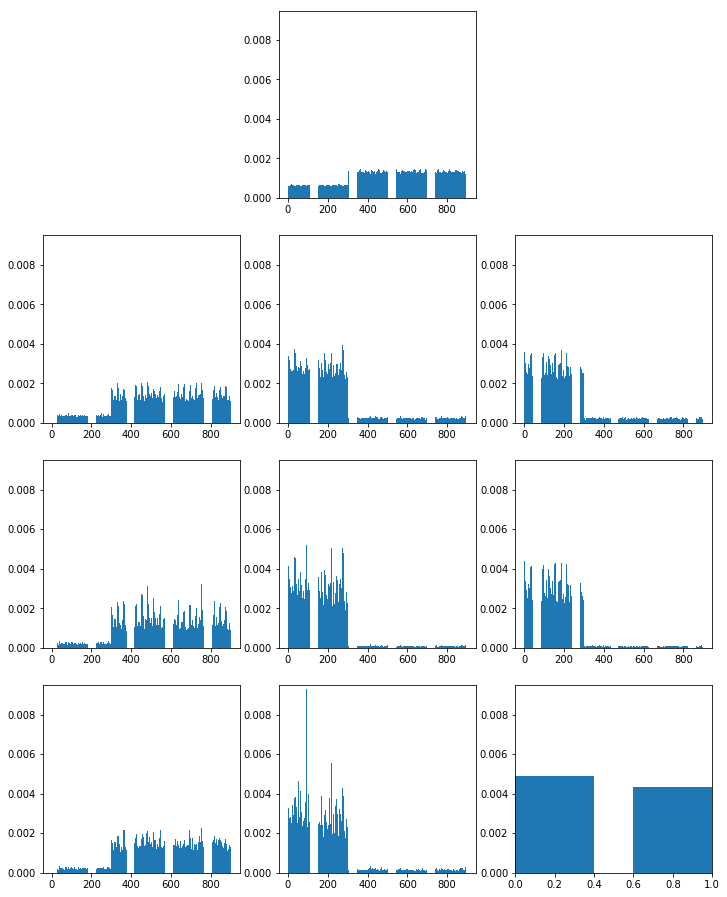

In [275]:
_topics_bow, = debug_value([topic_bow], return_value=True)

plt.figure(figsize=(12, 20))
    
_topic_bow = _topics_bow[0]
plt.subplot(5,3,2)
plt.ylim([0, np.max(_topics_bow)])
plt.bar(bow_idxs, _topic_bow)

for i in range(1, len(topic_idxs)):
    _topic_bow = _topics_bow[i]
    plt.subplot(5,3,i+3)
    plt.ylim([0, np.max(_topics_bow)])
#     plt.axis('off')
    plt.bar(bow_idxs, _topic_bow)

plt.show()

In [396]:
_prob_topics = []
for ct, batch in dev_batches:
    feed_dict = get_feed_dict(batch)
    _prob_topic, = sess.run([prob_topic], feed_dict = feed_dict)
    _prob_topics.append(_prob_topic)
    
_prob_topics = np.concatenate(_prob_topics, 0)
_prob_topic_mean = np.mean(_prob_topics, 0)

print(_prob_topic_mean)

[0.5237199  0.09850667 0.03493128 0.08216162 0.04138966 0.0197104
 0.08395018 0.01128574 0.00476593 0.03738718 0.00985148 0.00332517
 0.04901459]


In [398]:
debug_value([topic_dots])

clip_by_value:0 : [[1.         0.45967275 0.9349185  0.7218969  0.29530185 0.19406395
  0.33609834 0.24521929 0.2352042  0.257465   0.5190259  0.144616
  0.26576602]
 [0.45967275 0.9999998  0.28494376 0.16014685 0.6418538  0.54196584
  0.9728328  0.17134142 0.12358692 0.41502297 0.09197979 0.0786841
  0.42716378]
 [0.9349185  0.28494376 0.9999999  0.6461724  0.16898459 0.09094772
  0.14661686 0.19649531 0.1897769  0.11202296 0.44437054 0.09971987
  0.11693319]
 [0.7218969  0.16014685 0.6461724  1.         0.1333359  0.04837378
  0.05921422 0.14869294 0.13852736 0.02696049 0.7164618  0.11121432
  0.0307897 ]
 [0.29530185 0.6418538  0.16898459 0.1333359  1.         0.3467133
  0.630463   0.1273186  0.06801195 0.2171282  0.07531637 0.04693287
  0.22467637]
 [0.19406395 0.54196584 0.09094772 0.04837378 0.3467133  0.99999976
  0.5300827  0.06485982 0.08166274 0.15559971 0.02202802 0.06741525
  0.16640808]
 [0.33609834 0.9728328  0.14661686 0.05921422 0.630463   0.5300827
  1.         0.1537

In [399]:
debug_value([topic_losses_reg])

mul_2:0 : [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 3.19744231e-14 8.11929479e-02 2.56470125e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 2.93578822e-02
  1.52737275e-02 1.72244072e-01 8.46028142e-03 6.19118754e-03
  1.82468891e-01]
 [0.00000000e+00 8.11929479e-02 1.42108547e-14 4.17538762e-01
  2.85557918e-02 8.27148743e-03 2.14965045e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.97465181e-01 9.94405150e-03
  1.36733707e-02]
 [0.00000000e+00 2.56470125e-02 4.17538762e-01 0.00000000e+00
  1.77784637e-02 2.34002271e-03 3.50632379e-03 2.21095886e-02
  1.91898309e-02 7.26867933e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.85557918e-02 1.77784637e-02
  0.00000000e+00 1.20210119e-01 3.97483587e-01 1.62100270e-02
  4.62562591e-03 4.71446551e-02 5.67255542e-03 2.2

In [256]:
tree_mask_reg

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]],
      dtype=float32)

In [73]:
_topic_bow, = debug_value([topic_bow], return_value=True)

<BarContainer object of 900 artists>

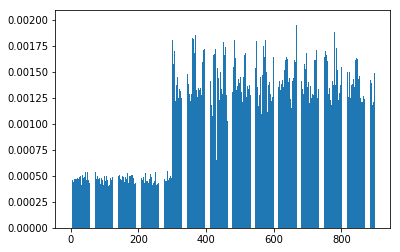

In [74]:
plt.bar(bow_idxs, _topic_bow[0])

<BarContainer object of 900 artists>

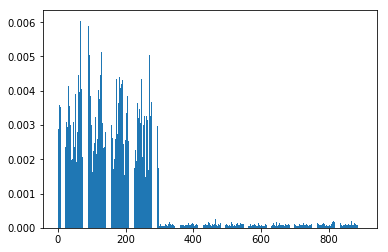

In [75]:
plt.bar(bow_idxs, _topic_bow[1])

<BarContainer object of 900 artists>

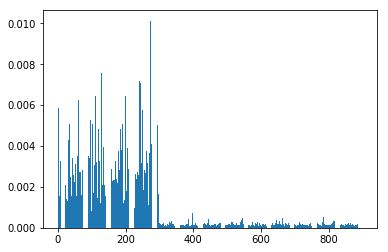

In [76]:
plt.bar(bow_idxs, _topic_bow[2])

<BarContainer object of 900 artists>

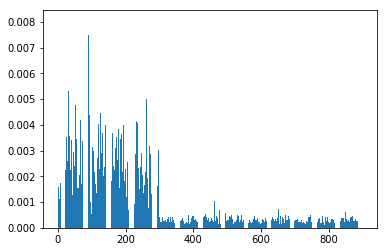

In [77]:
plt.bar(bow_idxs, _topic_bow[3])

In [29]:
np.max(_topic_bow, 1)

array([0.01918071, 0.02742062, 0.07750692, 0.30076486, 0.08144509,
       0.0605053 , 0.04116948, 0.13132279, 0.11353057, 0.03382822,
       0.07688902, 0.27393726, 0.12482085], dtype=float32)

<BarContainer object of 1035 artists>

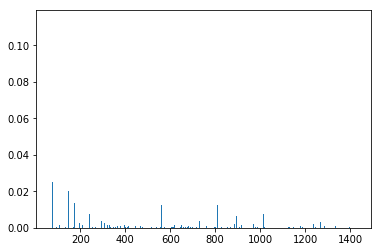

In [30]:
plt.bar(bow_idxs, _topic_bow[-5])

<BarContainer object of 1035 artists>

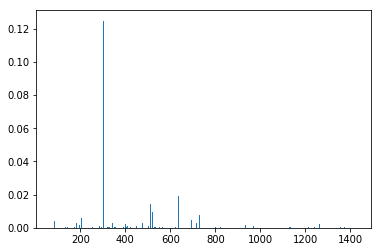

In [31]:
plt.bar(bow_idxs, _topic_bow[-1])

In [32]:
len(bow_idxs)

1035

In [33]:
debug_value([prob_topic[3]])

strided_slice:0 : [8.7924874e-01 1.4041331e-02 9.5688325e-04 2.1710899e-03 3.6867331e-03
 2.6053471e-02 6.0916133e-02 1.9192279e-04 1.2630331e-03 2.2021956e-03
 2.0566586e-04 1.7320737e-03 7.3307301e-03]


In [34]:
debug_value([tf.exp(-tf.divide(topic_losses_recon, n_bow))])

Exp_1:0 : [0.00195232 0.00321647 0.00281393 0.00188054 0.00115042 0.00221073
 0.00244512 0.0030191  0.00184192 0.00340065 0.00212078 0.00254592
 0.00427322 0.00224677 0.00293432 0.00166951 0.00158739 0.00313646
 0.00497206 0.00324249 0.00134879 0.00202139 0.002259   0.00333264
 0.00087564 0.00402948 0.00231731 0.00167068 0.00248191 0.00268275
 0.00212224 0.0025436  0.00388052 0.00222981 0.00248853 0.00187611
 0.00246348 0.00192031 0.00228528 0.00272792 0.0035063  0.00206707
 0.00262333 0.0017014  0.00217234 0.00355496 0.00147936 0.00249227
 0.00249496 0.00207853 0.00210985 0.00139918 0.00353285]


### test

In [35]:
debug_shape([bow, hidden_bow, latents_bow, prob_topic, bow_embeddings, topic_embeddings, topic_bow, prob_bow])

NameError: name 'bow' is not defined

In [ ]:
debug_shape([topic_losses_recon, topic_loss_recon, n_bow, ppls, topic_embeddings_norm, tf.expand_dims(topic_angles_mean, -1), topic_angles_vars])

In [ ]:
debug_value([tf.reduce_sum(tf.square(topic_embeddings_norm), 1)], return_value=True)[0]

In [ ]:
debug_value([tf.reduce_sum(prob_topic, -1), tf.reduce_sum(topic_bow, -1), tf.reduce_sum(tf.exp(prob_bow), 1)])

In [ ]:
sigma_bow = tf.exp(0.5 * logvars_bow)
dist_bow = tfd.Normal(means_bow, sigma_bow)
dist_std = tfd.Normal(0., 1.)
topic_loss_kl_tmp = tf.reduce_mean(tf.reduce_sum(tfd.kl_divergence(dist_bow, dist_std), 1))

In [ ]:
debug_value([topic_loss_recon, topic_loss_kl, topic_loss_kl_tmp])

In [ ]:
_logvars, _means, _kl_losses, _latents, _output_logits = sess.run([logvars, means, kl_losses, latents, output_logits], feed_dict=feed_dict)


In [ ]:
_logvars.shape, _means.shape, _kl_losses.shape, _latents.shape

In [ ]:
_output_logits

In [ ]:
_output_logits, _dec_target_idxs_do, _dec_mask_tokens_do, _recon_loss, _kl_losses, _ = sess.run([output_logits, dec_target_idxs_do, dec_mask_tokens_do, recon_loss, kl_losses, opt], feed_dict=feed_dict)


In [ ]:
tf.reduce_max(output_logits, 2).eval(session=sess, feed_dict=feed_dict).shape

In [ ]:
_output_logits.shape, _dec_target_idxs_do.shape, _dec_mask_tokens_do.shape

In [ ]:
_logits = np.exp(_output_logits) / np.sum(np.exp(_output_logits), 2)[:, :, None]

In [ ]:
_idxs = _dec_target_idxs_do

In [ ]:
_losses = np.array([[-np.log(_logits[i, j, _idxs[i, j]]) for j in range(_idxs.shape[1])] for i in range(_idxs.shape[0])]) * _dec_mask_tokens_do

In [ ]:
np.sum(_losses)/np.sum(_dec_mask_tokens_do)

In [ ]:
_recon_loss

In [ ]:
_kl_losses.shape